<h1>What is stixdcpy? </h1>
<p> stixdcpy allows  users to query and download data which are available at <a href="https://pub023.cs.technik.fhnw.ch/">STIX data center</a>, including </p> 
<ul>
<li> Quick-look light curves </li>
<li> Housekeeping data </li>
<li> Science data </li>
<li> Energy calibration data </li>
<li> Auxilary data </li>
<li> STIX solar flare list  </li>
 </ul>
<p>It also provides modules for use to preview the data. 
Note that data downloaded with stixdcpy are not validated. They should not be used for publication purpose. 
If you need validated data, please visit  solar orbiter data archive or contact us. 
</p>
Author: Hualin Xiao (<a href="mailto:hualin.xiao@fhnw.ch">hualin.xiao@fhnw.ch</a>)


# Install dependencies 

In [1]:
#!pip install git+https://github.com/drhlxiao/stixdcpy.git@analysis


In [2]:
import sys

sys.path.append('/home/xiaohl/FHNW/STIX/gsw/sdcpy')
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
import pandas as pd
from pprint import pprint

from astropy.table import QTable
from stixdcpy.quicklook import LightCurves
from stixdcpy.energylut import EnergyLUT
from stixdcpy import ancillary as anc
from stixdcpy.net import FitsQuery
from stixdcpy.net import JSONRequest as jreq
from stixdcpy import instrument as inst

from stixdcpy.science import ScienceL1, Spectrogram
from stixdcpy.housekeeping import Housekeeping
import matplotlib
#from plotly import __version__
%matplotlib inline

# Request Quick-look  data from STIX data center 

<AxesSubplot:xlabel='UTC + 94.66 (4 sec time bins)', ylabel='Counts'>

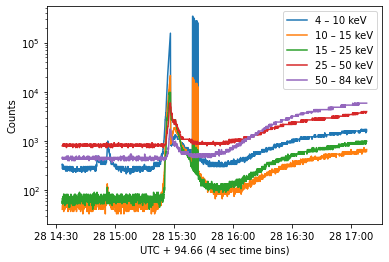

In [3]:

lc=LightCurves.from_sdc(start_utc='2021-10-28T15:00:00', end_utc='2021-10-28T17:00:00', ltc=True)
"""ltc:  boolean, optional
   True
     do light time correction if it is True, default value = False
"""
lc.peek()
#preview lightcurves


# Housekeep data

In [4]:
hk=Housekeeping.from_sdc('2021-02-14T05:00:00', '2021-02-14T07:00:00')
hk.param_names


{'NIX00020': 'SID',
 'NIXD0021': 'SW running',
 'NIXD0022': 'Instrument number',
 'NIXD0023': 'Instrument mode',
 'NIXD0025': 'HK_DPU_PCB_T',
 'NIXD0026': 'HK_DPU_FPGA_T',
 'NIXD0027': 'HK_DPU_3V3_C',
 'NIXD0028': 'HK_DPU_2V5_C',
 'NIXD0029': 'HK_DPU_1V5_C',
 'NIXD0030': 'HK_DPU_SPW_C',
 'NIXD0031': 'HK_DPU_SPW0_V',
 'NIXD0032': 'HK_DPU_SPW1_V',
 'NIXD0038': 'HK_ASP_REF_2V5A_V',
 'NIXD0039': 'HK_ASP_REF_2V5B_V',
 'NIXD0040': 'HK_ASP_TIM01_T',
 'NIXD0041': 'HK_ASP_TIM02_T',
 'NIXD0042': 'HK_ASP_TIM03_T',
 'NIXD0043': 'HK_ASP_TIM04_T',
 'NIXD0044': 'HK_ASP_TIM05_T',
 'NIXD0045': 'HK_ASP_TIM06_T',
 'NIXD0046': 'HK_ASP_TIM07_T',
 'NIXD0047': 'HK_ASP_TIM08_T',
 'NIXD0048': 'HK_ASP_VSENSA_V',
 'NIXD0049': 'HK_ASP_VSENSB_V',
 'NIXD0050': 'HK_ATT_V',
 'NIXD0051': 'HK_ATT_T',
 'NIXD0052': 'HK_HV_01_16_V',
 'NIXD0053': 'HK_HV_17_32_V',
 'NIXD0054': 'DET_Q1_T',
 'NIXD0055': 'DET_Q2_T',
 'NIXD0056': 'DET_Q3_T',
 'NIXD0057': 'DET_Q4_T',
 'NIXD0035': 'HK_DPU_1V5_V',
 'NIXD0036': 'HK_REF_2V5_V',
 'NI

<AxesSubplot:xlabel='UTC', ylabel='Value'>

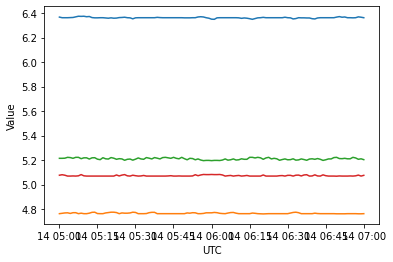

In [5]:

hk.plot('NIX00078,NIX00079,NIX00080,NIX00081')


# Calibration data

In [6]:
elut=EnergyLUT.request('2021-09-03T00:00:00')

In [7]:
#Print onboard elut and calibration run information
elut.info()
#elut.data


{'calibration_run': {'duration': 86400,
                     'obs_begin': '2021-09-02T12:56:17.958',
                     'run_id': 1353},
 'onboard_elut': {'upload_time_range': ['2021-06-25T14:54:14.456',
                                        '2021-06-25T14:55:49.456']}}


In [8]:
lut=elut.get_pixel_true_ebins(pixel=34)
#print the energy range of bins of pixel 34 
pd.DataFrame(lut)

,0,1
0,-0.100,3.911
1,3.911,4.914
2,4.914,5.917
3,5.917,6.919
4,6.919,7.922
5,7.922,8.925
6,8.925,9.928
7,9.928,10.930
8,10.930,11.933
9,11.933,12.936


# S/C Ephemeris 

<AxesSubplot:title={'center':'SOLO Location at 2022-02-21T00:00:00'}, xlabel='X (au)', ylabel='Y (au)'>

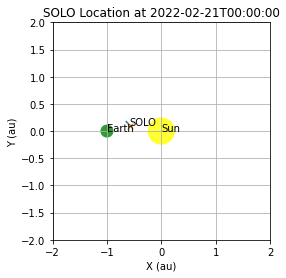

In [9]:
emph=anc.Ephemeris.from_sdc(start_utc='2022-02-21T00:00:00', end_utc='2022-02-28T01:00:00')
emph.peek()

In [10]:
emph.data

{'orbit': {'ref_frame': 'SOLO_HEE_NASA',
  'observer': 'Earth',
  'aunit': 'deg',
  'lunit': 'au',
  'vunit': 'km/s',
  'tunit': 's',
  'utc': ['2022-02-21T00:00:00Z',
   '2022-02-21T13:00:00Z',
   '2022-02-22T02:00:00Z',
   '2022-02-22T15:00:00Z',
   '2022-02-23T04:00:00Z',
   '2022-02-23T17:00:00Z',
   '2022-02-24T06:00:00Z',
   '2022-02-24T19:00:00Z',
   '2022-02-25T08:00:00Z',
   '2022-02-25T21:00:00Z',
   '2022-02-26T10:00:00Z',
   '2022-02-26T23:00:00Z',
   '2022-02-27T12:00:00Z',
   '2022-02-28T01:00:00Z'],
  'x': [-0.6448116874133832,
   -0.6399849413870209,
   -0.635119877109572,
   -0.6302147004311194,
   -0.6252674874319075,
   -0.6202761773524547,
   -0.6152385651213691,
   -0.610152293465356,
   -0.6050148445950866,
   -0.5998235314531997,
   -0.5945754885225142,
   -0.5892676621910331,
   -0.5838968006809313,
   -0.5784594435550895],
  'y': [0.17470687776316685,
   0.16983587377947484,
   0.16483616252538005,
   0.1597067099439808,
   0.15444649448135986,
   0.14905451034

# STIX pointing info

<AxesSubplot:title={'center':'Solar center: [176.2, 1979.6]  arcsec '}, xlabel='STIX X (arcsec)', ylabel='STIX Y (arcsec)'>

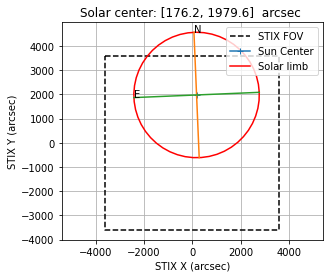

In [11]:
fov=anc.STIXPointing.from_sdc('2022-03-18T00:00:00')
fov.peek()

In [12]:
print(fov.data)

{'sun_center': [176.22790045554788, 1979.6231622035357], 'frame': 'STIX_ILS', 'fov': {'x': [-3600, 3600, 3600, -3600, -3600], 'y': [3600, 3600, -3600, -3600, 3600]}, 'limb': {'x': [2767.970923653813, 2732.8118827667604, 2655.6778602255954, 2537.8342199034814, 2381.2143339360623, 2188.388063778501, 1962.5198192788628, 1707.3168477801546, 1426.968566875727, 1126.0779078217288, 809.58577831615, 482.68987952592676, 150.75921888669717, -180.7542564690797, -506.4054239923149, -820.8456380749957, -1118.9107629078073, -1395.7061102532823, -1646.686867150879, -1867.7326853362592, -2055.215213790163, -2206.057484509608, -2317.7842053275594, -2388.5621685832552, -2417.2301472986933, -2403.3178185038937, -2347.053424405078, -2249.3600547430906, -2111.840606914188, -1936.7516533782918, -1726.9666176262765, -1485.9288292291164, -1217.5951934026982, -926.371368583279, -617.0394935568258, -294.67964003614486, 35.41371673053793, 367.81882162842214, 697.075899925772, 1017.777054277467, 1324.655286140047

# Science data

##  L1 data products

In [13]:
sci_data=ScienceL1.from_sdc(request_id=2105090003)
#Bulk science data request ids (also called unique ids) can be found on the science data web page at STIX data center

ERROR: b'{"error":"The requested file does not exists! "}\n'
2105090003 None


Exception: FITS filename not specified

In [ ]:
hdul=sci_data.hdul
hdul.info()



In [ ]:
sci_data.peek('spg,lc')
#science data quicklook

## Spectrogram products

In [ ]:
request_id=	2108150003
l4d=Spectrogram.from_sdc(request_id=request_id)
#fetch data from STIX data center

In [ ]:
l4d.hdul.info()
l4d.peek()

# Data search and data download

In [ ]:
#res=None
res=FitsQuery.query(start_utc='2021-05-04T05:00:00', stop_utc='2021-05-08T07:00:00',product_type='lc')
#print(res)

In [ ]:
res.to_pandas()

In [ ]:
fits_list=res.fetch()

In [ ]:
hduls=res.open_fits()


In [ ]:
res.fits_info()

# Download flare list

In [ ]:
flares=jreq.fetch_flare_list('2020-04-08T00:00:00',  '2021-12-09T00:00:00', sort='goes' )
#sort key can be LC0, LC1, LC2, LC3, LC4, time, goes

pd.DataFrame(flares)